In [199]:
import os, time, math
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
import os

for root, dirs, files in os.walk("/kaggle/input"):
    print(root)
    break


/kaggle/input


In [5]:
for root, dirs, files in os.walk("/kaggle/input/vehicle-detection-image-set"):
    print(root, "->", len(files))


/kaggle/input/vehicle-detection-image-set -> 0
/kaggle/input/vehicle-detection-image-set/data -> 0
/kaggle/input/vehicle-detection-image-set/data/vehicles -> 8792
/kaggle/input/vehicle-detection-image-set/data/non-vehicles -> 8968


In [6]:
import tensorflow as tf

DATA_DIR = "/kaggle/input/vehicle-detection-image-set/data"
IMG_SIZE = (128, 128)
BATCH = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.2,
    subset="training",
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names
print("Classes:", class_names)  # should be ['non-vehicles', 'vehicles']


Found 17760 files belonging to 2 classes.
Using 14208 files for training.


I0000 00:00:1765676468.817548      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765676468.818150      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 17760 files belonging to 2 classes.
Using 3552 files for validation.
Classes: ['non-vehicles', 'vehicles']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def norm(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = train_ds.map(norm).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.map(norm).cache().prefetch(AUTOTUNE)


In [8]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,195,105 (8.37 MB)

 Trainable params: 2,195,105 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "vehicle_binary_best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True
    )
]

hist = model.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=callbacks)


Epoch 1/12
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9950 - loss: 0.0144 - val_accuracy: 0.9901 - val_loss: 0.0304
Epoch 2/12
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9977 - loss: 0.0069 - val_accuracy: 0.9935 - val_loss: 0.0199
Epoch 3/12
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9959 - loss: 0.0126 - val_accuracy: 0.9961 - val_loss: 0.0129
Epoch 4/12
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.9958 - val_loss: 0.0099
Epoch 5/12
444/444 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9989 - loss: 0.0032 - val_accuracy: 0.9941 - val_loss: 0.0173


In [11]:
model.save("vehicle_binary_final.keras")


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for xb, yb in val_ds:
    p = model.predict(xb, verbose=0).ravel()
    y_pred.extend((p >= 0.5).astype(int).tolist())
    y_true.extend(yb.numpy().astype(int).ravel().tolist())

print(classification_report(y_true, y_pred, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

non-vehicles       1.00      0.99      1.00      1743
    vehicles       0.99      1.00      1.00      1809

    accuracy                           1.00      3552
   macro avg       1.00      1.00      1.00      3552
weighted avg       1.00      1.00      1.00      3552

Confusion matrix:
 [[1733   10]
 [   4 1805]]


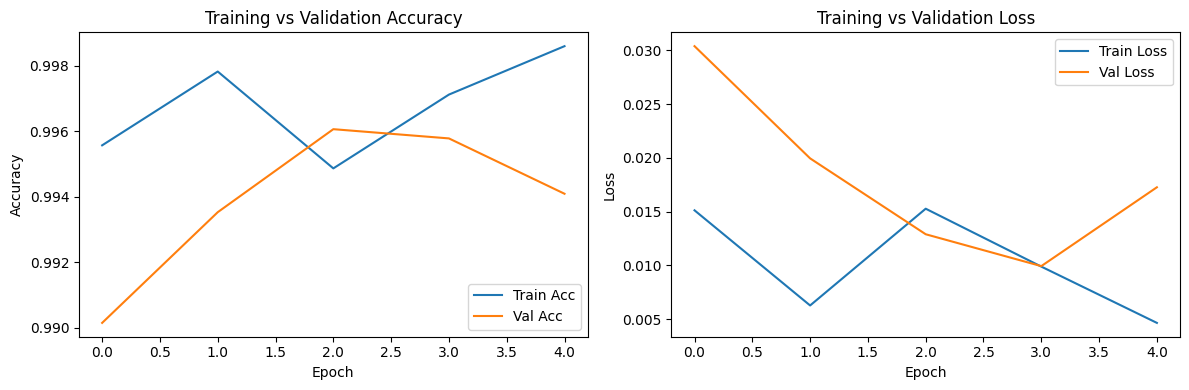

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist.history["accuracy"], label="Train Acc")
plt.plot(hist.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(hist.history["loss"], label="Train Loss")
plt.plot(hist.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


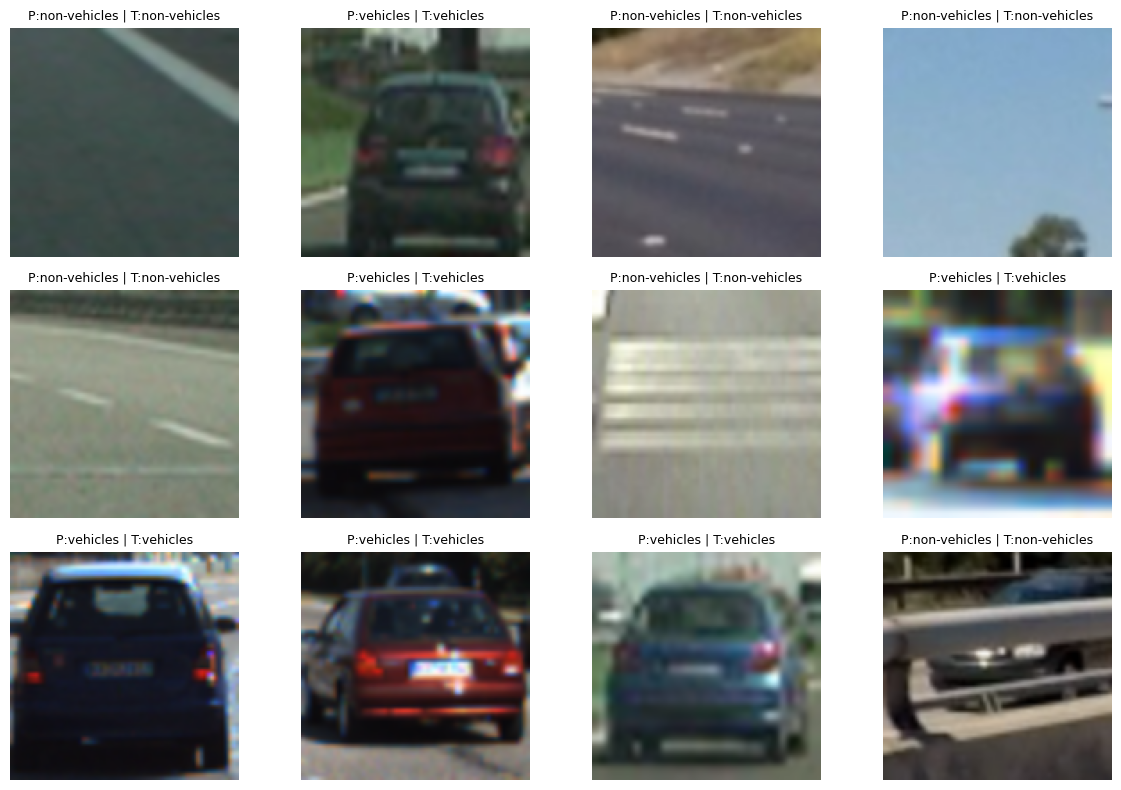

In [14]:
plt.figure(figsize=(12,8))
for images, labels in val_ds.take(1):
    preds = model.predict(images).ravel()
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i])
        pred_label = class_names[int(preds[i] >= 0.5)]
        true_label = class_names[int(labels[i])]
        plt.title(f"P:{pred_label} | T:{true_label}", fontsize=9)
        plt.axis("off")
plt.tight_layout()
plt.show()


In [164]:
!pip -q install gdown
import gdown, os

VIDEO_URL = "https://drive.google.com/uc?export=download&id=17BLLWPJP4hpzLw135SI3rQPaWtItM0lR"
video_path = "m6-motorway-trim.mp4"
if not os.path.exists(video_path):
    gdown.download(VIDEO_URL, video_path, quiet=False)

print("Video exists:", os.path.exists(video_path), video_path)


Video exists: True m6-motorway-trim.mp4


FPS: 25.0 Resolution: 1920 x 1080


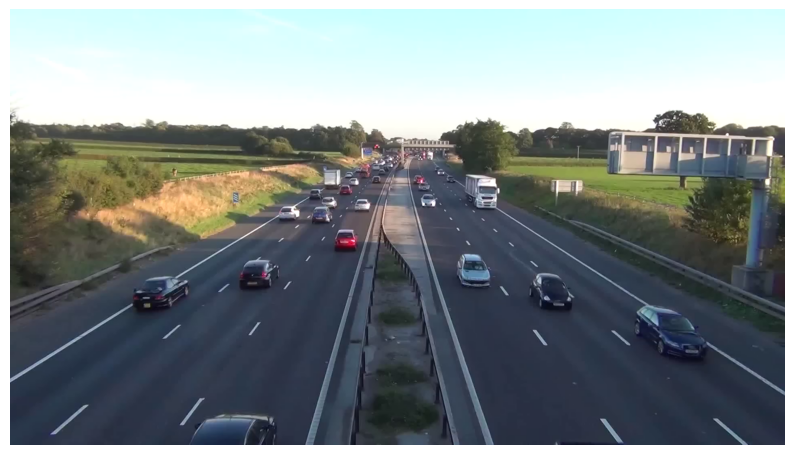

In [16]:
import cv2, matplotlib.pyplot as plt

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ret, frame = cap.read()
cap.release()

print("FPS:", fps, "Resolution:", w, "x", h)
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [200]:

import numpy as np
import cv2
import math

class CentroidTracker:
    def __init__(self, max_lost=10, dist_thresh=60):
        self.next_id = 0
        self.tracks = {}   
        self.max_lost = max_lost
        self.dist_thresh = dist_thresh

    def update(self, detections):
       
        det_centroids = []
        for (x,y,w,h) in detections:
            det_centroids.append((int(x+w/2), int(y+h/2)))

        
        if len(self.tracks) == 0:
            for i, bbox in enumerate(detections):
                self._register(det_centroids[i], bbox)
            return self.tracks

        # if no detections, mark tracks lost
        if len(detections) == 0:
            to_del = []
            for tid in self.tracks:
                self.tracks[tid]["lost"] += 1
                if self.tracks[tid]["lost"] > self.max_lost:
                    to_del.append(tid)
            for tid in to_del:
                del self.tracks[tid]
            return self.tracks

        
        track_ids = list(self.tracks.keys())
        track_centroids = [self.tracks[tid]["centroid"] for tid in track_ids]

        D = np.zeros((len(track_centroids), len(det_centroids)), dtype=np.float32)
        for i, tc in enumerate(track_centroids):
            for j, dc in enumerate(det_centroids):
                D[i, j] = math.dist(tc, dc)

        used_tracks = set()
        used_dets = set()

        while True:
            i, j = np.unravel_index(np.argmin(D), D.shape)
            if D[i, j] > self.dist_thresh:
                break
            tid = track_ids[i]
            if tid in used_tracks or j in used_dets:
                D[i, j] = 1e9
                if np.min(D) >= 1e9:
                    break
                continue

            # assign
            self.tracks[tid]["centroid"] = det_centroids[j]
            self.tracks[tid]["bbox"] = detections[j]
            self.tracks[tid]["lost"] = 0
            self.tracks[tid]["history"].append(det_centroids[j])

            used_tracks.add(tid)
            used_dets.add(j)

            D[i, :] = 1e9
            D[:, j] = 1e9
            if np.min(D) >= 1e9:
                break

        # unmatched tracks -> increment lost
        to_del = []
        for tid in track_ids:
            if tid not in used_tracks:
                self.tracks[tid]["lost"] += 1
                if self.tracks[tid]["lost"] > self.max_lost:
                    to_del.append(tid)
        for tid in to_del:
            del self.tracks[tid]

        # unmatched detections -> register
        for j in range(len(detections)):
            if j not in used_dets:
                self._register(det_centroids[j], detections[j])

        return self.tracks

    def _register(self, centroid, bbox):
        self.tracks[self.next_id] = {
            "centroid": centroid,
            "bbox": bbox,
            "lost": 0,
            "history": [centroid]
        }
        self.next_id += 1


In [201]:

def estimate_speed_px_per_s(history, fps, window=5):
    # speed based on last 'window' movements
    if len(history) < window + 1:
        return None
    p1 = history[-(window+1)]
    p2 = history[-1]
    dist_px = math.dist(p1, p2)
    time_s = window / fps
    return dist_px / time_s  # px/s


In [35]:
import numpy as np
import cv2

IMG_SIZE = (128, 128)  # must match training

def vehicle_prob_from_bbox(frame_bgr, bbox, model, img_size=IMG_SIZE):
    x, y, w, h = bbox
    H, W = frame_bgr.shape[:2]
    x0, y0 = max(0, x), max(0, y)
    x1, y1 = min(W, x + w), min(H, y + h)

    crop = frame_bgr[y0:y1, x0:x1]
    if crop.size == 0:
        return 0.0

    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    crop = cv2.resize(crop, img_size)
    crop = crop.astype(np.float32) / 255.0
    crop = np.expand_dims(crop, axis=0)

    p = float(model.predict(crop, verbose=0).ravel()[0])  # sigmoid
    return p


In [181]:

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#out_path = "annotated_tracking_cnn.mp4"

out_path = "annotated_tracking_cnn_v2.mp4"
csv_path = "track_speeds_pxps_cnn_v2.csv"


fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))



bg = cv2.createBackgroundSubtractorMOG2(
    history=500,
    varThreshold=32,
    detectShadows=True
)

tracker = CentroidTracker(max_lost=10, dist_thresh=60)

frame_count = 0
MAX_FRAMES = 1200  

import csv

speed_rows = []  


while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    roi = frame[int(h*0.35):, :]
    roi_y_offset = int(h*0.35)

    fg = bg.apply(roi)

   
    fg[fg == 127] = 0

    fg = cv2.medianBlur(fg, 5)
    _, fg = cv2.threshold(fg, 200, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel, iterations=1)
    fg = cv2.morphologyEx(fg, cv2.MORPH_DILATE, kernel, iterations=2)

    contours, _ = cv2.findContours(fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detections = []
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area < 900:
            continue

        x, y, wc, hc = cv2.boundingRect(c)

        box_area = wc * hc
        aspect = wc / float(hc + 1e-6)

        if box_area < 1400:
            continue
        if hc < 25 or wc < 25:
            continue
        if aspect < 0.6 or aspect > 3.5:
            continue

        detections.append((x, y + roi_y_offset, wc, hc))

    tracks = tracker.update(detections)

   
    for tid, t in tracks.items():
        if len(t["history"]) < 12:
            continue

        x, y, wc, hc = t["bbox"]
        aspect = wc / float(hc + 1e-6)
        if aspect > 4.5 or aspect < 0.2:
            continue

        # Skip boxes too close to bottom (often road markings)
        if (y + hc) > int(h * 0.95):
            continue

        cx, cy = t["centroid"]
        sp = estimate_speed_px_per_s(t["history"], fps, window=5)

        # CNN gate
        tbbox = (x, y, wc, hc)
        pveh = vehicle_prob_from_bbox(frame, t["bbox"], model)
        if pveh < 0.70:
            continue

        # log speed row
        if sp is not None:
            speed_rows.append([frame_count, tid, cx, cy, sp])

        # DRAW rectangle + label
        cv2.rectangle(frame, (x, y), (x + wc, y + hc), (0, 255, 0), 2)

        label = f"ID {tid} | p={pveh:.2f}"
        if sp is not None:
            label += f" | {sp:.1f} px/s"

        cv2.putText(frame, label, (x, max(20, y - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

   
    writer.write(frame)


#csv_path = "track_speeds_pxps_cnn.csv"
with open(csv_path, "w", newline="") as f:
    wcsv = csv.writer(f)
    wcsv.writerow(["frame", "track_id", "cx", "cy", "speed_px_per_s"])
    wcsv.writerows(speed_rows)

cap.release()
writer.release()

print("Saved:", out_path)
print("Saved CSV:", csv_path, "rows:", len(speed_rows))



Saved: annotated_tracking_cnn_v2.mp4
Saved CSV: track_speeds_pxps_cnn_v2.csv rows: 1419


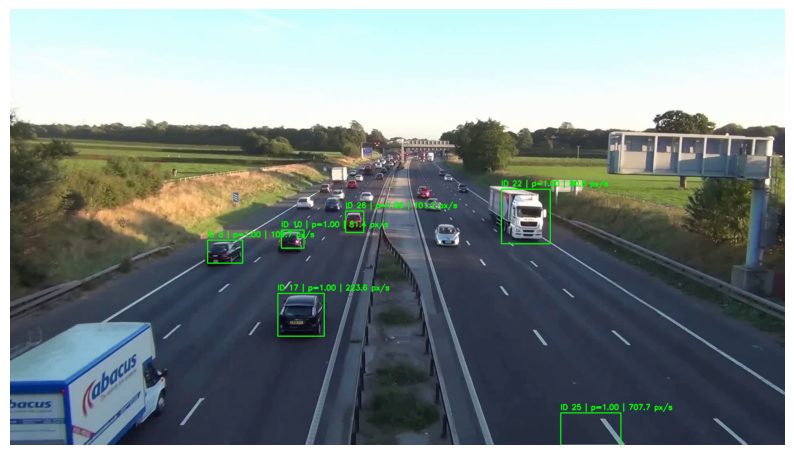

In [82]:
import matplotlib.pyplot as plt
cap = cv2.VideoCapture("annotated_tracking_cnn.mp4")
for _ in range(30):
    cap.read()
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [53]:
from IPython.display import FileLink
FileLink("annotated_tracking_cnn.mp4")


/kaggle/working/annotated_tracking_cnn.mp4

Top track IDs: [294, 119, 202, 39, 192]


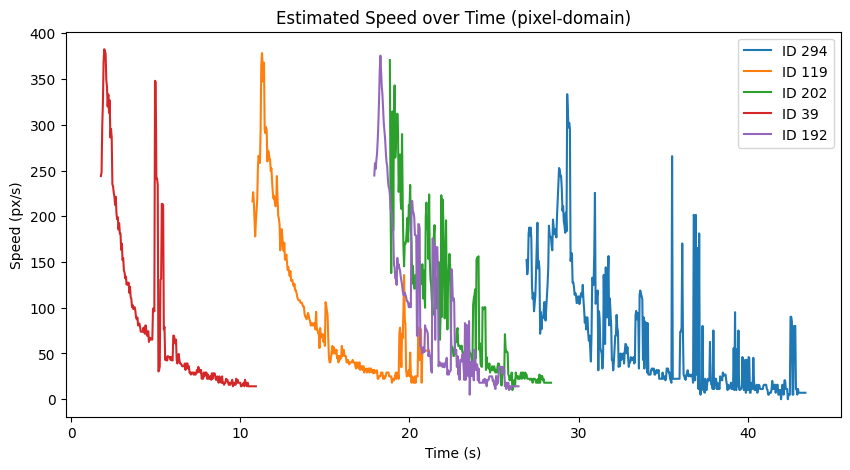

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("track_speeds_pxps.csv")

# convert frame -> seconds
df["time_s"] = df["frame"] / fps

# pick top 5 longest tracks (most points)
top_ids = df["track_id"].value_counts().head(5).index.tolist()
print("Top track IDs:", top_ids)

plt.figure(figsize=(10,5))
for tid in top_ids:
    d = df[df["track_id"] == tid].sort_values("time_s")
    plt.plot(d["time_s"], d["speed_px_per_s"], label=f"ID {tid}")

plt.xlabel("Time (s)")
plt.ylabel("Speed (px/s)")
plt.title("Estimated Speed over Time (pixel-domain)")
plt.legend()
plt.show()


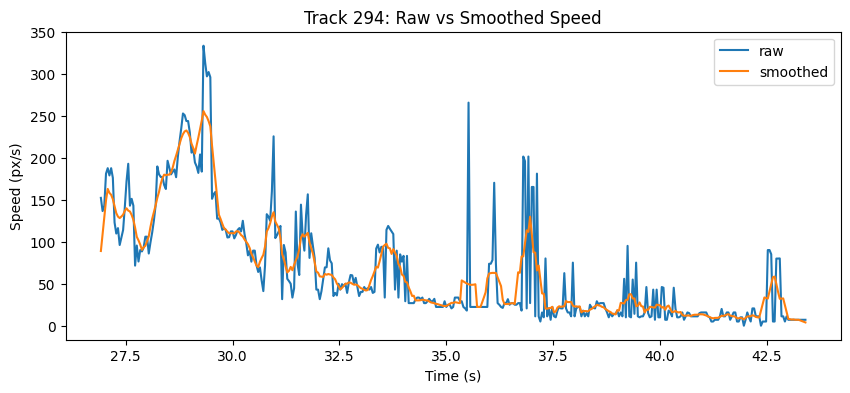

In [55]:
def moving_average(x, k=7):
    return np.convolve(x, np.ones(k)/k, mode="same")

tid = top_ids[0]
d = df[df["track_id"] == tid].sort_values("time_s")

raw = d["speed_px_per_s"].values
sm  = moving_average(raw, k=9)

plt.figure(figsize=(10,4))
plt.plot(d["time_s"], raw, label="raw")
plt.plot(d["time_s"], sm, label="smoothed")
plt.xlabel("Time (s)")
plt.ylabel("Speed (px/s)")
plt.title(f"Track {tid}: Raw vs Smoothed Speed")
plt.legend()
plt.show()


In [51]:
from IPython.display import FileLink
FileLink("track_speeds_pxps.csv")


/kaggle/working/track_speeds_pxps.csv

## Speed Conversion: Pixels/sec to MPH


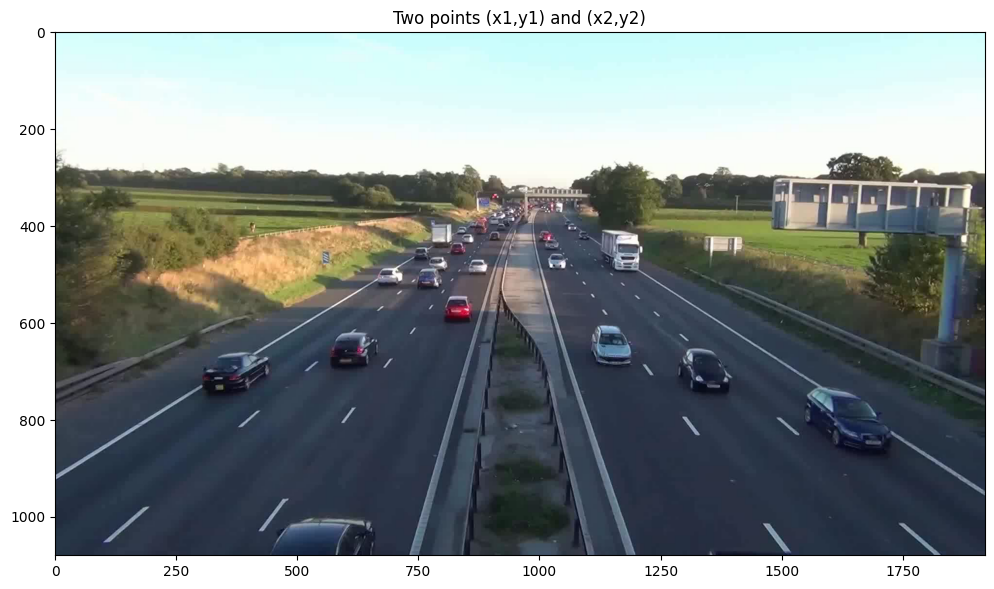

In [81]:
import cv2, matplotlib.pyplot as plt

cap = cv2.VideoCapture("annotated_tracking_cnn.mp4")
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Two points (x1,y1) and (x2,y2)")
plt.axis("on")
plt.show()


In [74]:
import math

x1, y1 = 1160, 800
x2, y2 = 1260, 800

lane_px = math.dist((x1, y1), (x2, y2))
print("Lane width (pixels):", lane_px)


Lane width (pixels): 100.0


In [75]:
LANE_WIDTH_METERS = 3.65  # standard motorway lane width
meters_per_pixel = LANE_WIDTH_METERS / lane_px

print("Meters per pixel:", meters_per_pixel)


Meters per pixel: 0.0365


In [76]:
import pandas as pd

df = pd.read_csv("track_speeds_pxps_cnn.csv")

df["speed_mps"] = df["speed_px_per_s"] * meters_per_pixel
df["speed_mph"] = df["speed_mps"] * 2.23694

df.to_csv("track_speeds_mph.csv", index=False)
print("Saved track_speeds_mph.csv")


Saved track_speeds_mph.csv


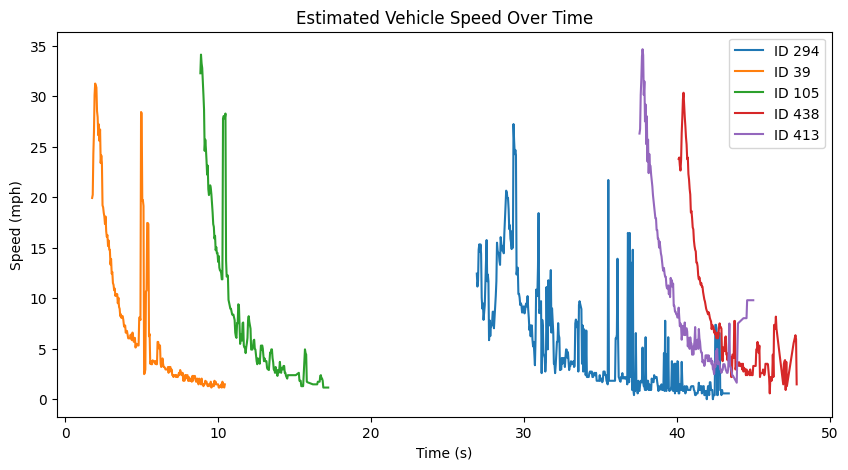

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
top_ids = df["track_id"].value_counts().head(5).index
for tid in top_ids:
    d = df[df["track_id"] == tid]
    plt.plot(d["frame"]/fps, d["speed_mph"], label=f"ID {tid}")

plt.xlabel("Time (s)")
plt.ylabel("Speed (mph)")
plt.title("Estimated Vehicle Speed Over Time")
plt.legend()
plt.show()


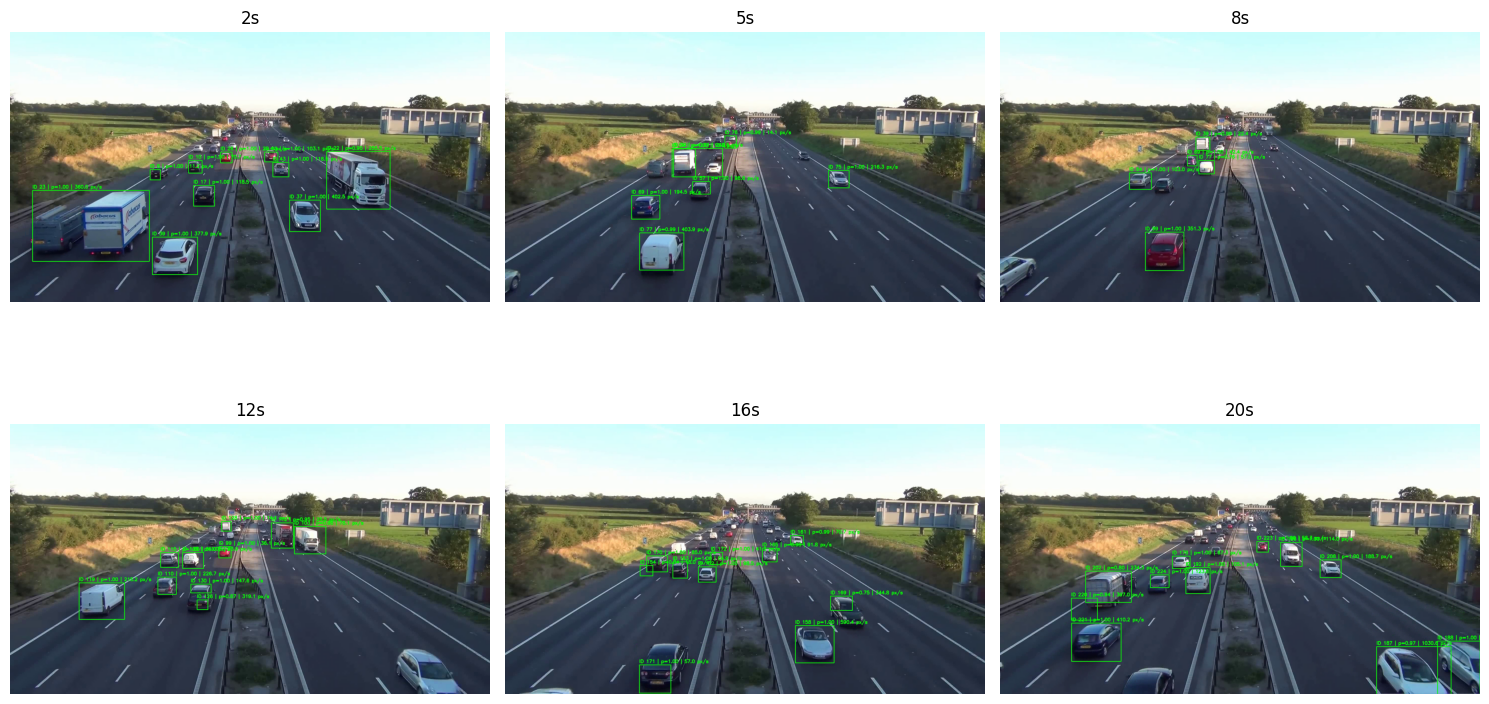

In [78]:
import cv2
import matplotlib.pyplot as plt

video_path = "annotated_tracking_cnn.mp4"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

times = [2, 5, 8, 12, 16, 20]  # seconds
plt.figure(figsize=(15,9))

for i, t_sec in enumerate(times, 1):
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(t_sec * fps))
    ret, frame = cap.read()
    if not ret:
        continue
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(2, 3, i)
    ax.imshow(frame_rgb)
    ax.set_title(f"{t_sec}s")
    ax.axis("off")

cap.release()
plt.tight_layout()
plt.show()


In [83]:
df.groupby("track_id")["speed_mph"].std().describe()
skybridge_traffic_13s.mp4


count    247.000000
mean       7.806894
std        6.424853
min        0.000000
25%        2.680519
50%        6.516963
75%       10.155246
max       26.982087
Name: speed_mph, dtype: float64

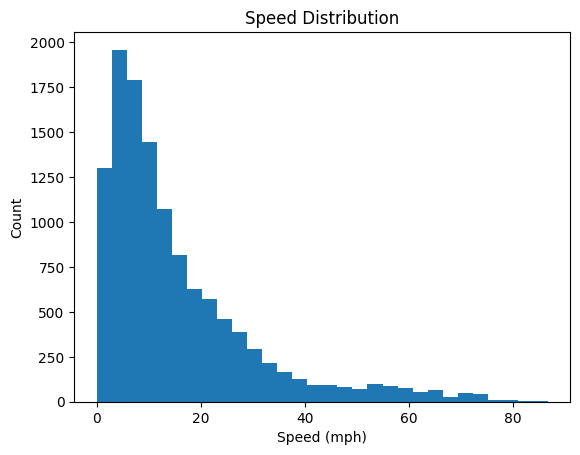

In [84]:
plt.hist(df["speed_mph"], bins=30)
plt.xlabel("Speed (mph)")
plt.ylabel("Count")
plt.title("Speed Distribution")
plt.show()


# Testing with everyday traffic

In [86]:
import os

print("Model exists:", os.path.exists("vehicle_binary_final.keras"))
print("Video exists:", os.path.exists(
    "/kaggle/input/ytinput/YTDown.com_Shorts_Sky-bridge-over-the-river-bridge-riversi_Media_opPstOQ2KXc_002_720p.mp4"
))


Model exists: True
Video exists: True


In [87]:
import tensorflow as tf

model = tf.keras.models.load_model("vehicle_binary_final.keras")
print("Model loaded successfully")


Model loaded successfully


In [176]:

video_path = "/kaggle/input/ytinput/YTDown.com_Shorts_Sky-bridge-over-the-river-bridge-riversi_Media_opPstOQ2KXc_002_720p.mp4"
out_path   = "annotated_skybridge_cnn.mp4"

MAX_FRAMES = 400  


In [89]:
import cv2

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

print("FPS:", fps, "Resolution:", w, "x", h)


FPS: 30.0 Resolution: 720 x 1280


In [90]:
bg = cv2.createBackgroundSubtractorMOG2(
    history=300,
    varThreshold=32,
    detectShadows=True
)

tracker = CentroidTracker(max_lost=8, dist_thresh=60)


In [91]:
import numpy as np
import csv

frame_count = 0
speed_rows = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    # ROI (lower half)
    roi = frame[int(h*0.35):, :]
    roi_y_offset = int(h*0.35)

    fg = bg.apply(roi)
    fg[fg == 127] = 0
    fg = cv2.medianBlur(fg, 5)
    _, fg = cv2.threshold(fg, 200, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel, iterations=1)
    fg = cv2.morphologyEx(fg, cv2.MORPH_DILATE, kernel, iterations=2)

    contours, _ = cv2.findContours(fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detections = []
    for c in contours:
        if cv2.contourArea(c) < 900:
            continue

        x,y,wc,hc = cv2.boundingRect(c)
        aspect = wc / float(hc + 1e-6)
        if wc*hc < 1400 or hc < 25 or aspect < 0.6 or aspect > 3.5:
            continue

        detections.append((x, y + roi_y_offset, wc, hc))

    tracks = tracker.update(detections)

    for tid, t in tracks.items():
        if len(t["history"]) < 6:
            continue

        x,y,wc,hc = t["bbox"]
        cx, cy = t["centroid"]

        pveh = vehicle_prob_from_bbox(frame, t["bbox"], model)
        if pveh < 0.70:
            continue

        sp = estimate_speed_px_per_s(t["history"], fps, window=5)

        if sp is not None:
            speed_rows.append([frame_count, tid, cx, cy, sp])

        cv2.rectangle(frame, (x,y), (x+wc,y+hc), (0,255,0), 2)
        label = f"ID {tid} | p={pveh:.2f}"
        if sp is not None:
            label += f" | {sp:.1f} px/s"

        cv2.putText(frame, label, (x, max(20,y-8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    writer.write(frame)

cap.release()
writer.release()

print("Saved:", out_path)


Saved: annotated_skybridge_cnn.mp4


In [92]:
with open("skybridge_speeds_pxps.csv", "w", newline="") as f:
    wcsv = csv.writer(f)
    wcsv.writerow(["frame","track_id","cx","cy","speed_pxps"])
    wcsv.writerows(speed_rows)

print("Saved skybridge_speeds_pxps.csv")


Saved skybridge_speeds_pxps.csv


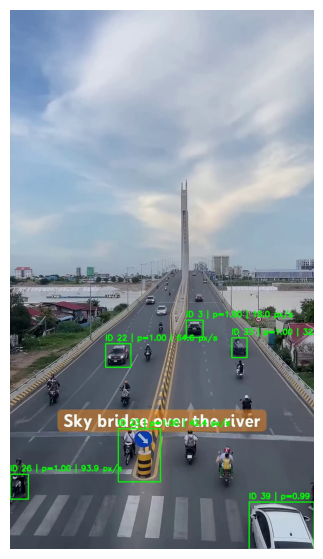

In [93]:
cap = cv2.VideoCapture("annotated_skybridge_cnn.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 150)
ret, frame = cap.read()
cap.release()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [95]:
from IPython.display import FileLink
FileLink("annotated_skybridge_cnn.mp4")


/kaggle/working/annotated_skybridge_cnn.mp4

In [102]:
import os, shutil, xml.etree.ElementTree as ET
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

RAW_ROOT = "/input/vehicle-detection-8-classes-object-detection"  
IMG_DIR = os.path.join(RAW_ROOT, "images")       
ANN_DIR = os.path.join(RAW_ROOT, "annotations")  

CLASS_DATA_ROOT = "/kaggle/working/vehicletype_data"  
IMGSIZE = (128, 128)  


In [107]:
import os

TRAIN_ROOT = "/kaggle/input/vehicle-detection-8-classes-object-detection/train"
print("TRAIN_ROOT contents:", os.listdir(TRAIN_ROOT))

for root, dirs, files in os.walk(TRAIN_ROOT):
    print(root, "dirs:", dirs[:5], "files:", files[:5])
    break


TRAIN_ROOT contents: ['labels', 'labels.npy', 'images']
/kaggle/input/vehicle-detection-8-classes-object-detection/train dirs: ['labels', 'images'] files: ['labels.npy']


In [108]:
IMG_DIR = os.path.join(TRAIN_ROOT, "images")          
ANN_DIR = os.path.join(TRAIN_ROOT, "labels") 

print("IMG_DIR:", IMG_DIR, os.path.exists(IMG_DIR))
print("ANN_DIR:", ANN_DIR, os.path.exists(ANN_DIR))


IMG_DIR: /kaggle/input/vehicle-detection-8-classes-object-detection/train/images True
ANN_DIR: /kaggle/input/vehicle-detection-8-classes-object-detection/train/labels True


In [109]:
import os, xml.etree.ElementTree as ET
import cv2

CLASS_DATA_ROOT = "/kaggle/working/vehicletype_data"
IMGSIZE = (128, 128)

os.makedirs(CLASS_DATA_ROOT, exist_ok=True)

LABEL_MAP = {
    "car": "car",
    "truck": "truck",
    "bus": "bus",
    "motorcycle": "motorcycle",
    "auto": "auto",
    "light_motor_vehicle": "light_motor_vehicle",
    "multi-axle": "multi_axle",
    "tractor": "tractor",
}

KEEP_LABELS = {"car", "truck", "bus", "motorcycle"}  

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def process_one_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    img_path = os.path.join(IMG_DIR, filename)
    if not os.path.exists(img_path):
        return 0

    img = cv2.imread(img_path)
    if img is None:
        return 0
    H, W = img.shape[:2]

    count = 0
    for obj in root.findall("object"):
        name = obj.find("name").text
        if name not in LABEL_MAP:
            continue
        mapped = LABEL_MAP[name]
        if KEEP_LABELS is not None and mapped not in KEEP_LABELS:
            continue

        bnd = obj.find("bndbox")
        xmin = int(float(bnd.find("xmin").text))
        ymin = int(float(bnd.find("ymin").text))
        xmax = int(float(bnd.find("xmax").text))
        ymax = int(float(bnd.find("ymax").text))

        xmin = max(0, min(xmin, W - 1))
        xmax = max(0, min(xmax, W - 1))
        ymin = max(0, min(ymin, H - 1))
        ymax = max(0, min(ymax, H - 1))
        if xmax <= xmin or ymax <= ymin:
            continue

        crop = img[ymin:ymax, xmin:xmax]
        if crop.size == 0:
            continue

        crop = cv2.resize(crop, IMGSIZE)
        out_dir = os.path.join(CLASS_DATA_ROOT, mapped)
        ensure_dir(out_dir)
        out_name = f"{os.path.splitext(filename)[0]}_{count}.jpg"
        cv2.imwrite(os.path.join(out_dir, out_name), crop)
        count += 1

    return count


In [110]:
total = 0
for f in os.listdir(ANN_DIR):
    if not f.lower().endswith(".xml"):
        continue
    total += process_one_xml(os.path.join(ANN_DIR, f))

print("Total cropped patches:", total)
print("Per class:", {
    c: len(os.listdir(os.path.join(CLASS_DATA_ROOT, c)))
    for c in os.listdir(CLASS_DATA_ROOT)
})


Total cropped patches: 0
Per class: {}


In [120]:
import tensorflow as tf
from tensorflow.keras import layers

BATCH = 64
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    CLASS_DATA_ROOT,
    labels="inferred",
    label_mode="categorical",
    image_size=IMGSIZE,
    batch_size=BATCH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    CLASS_DATA_ROOT,
    labels="inferred",
    label_mode="categorical",
    image_size=IMGSIZE,
    batch_size=BATCH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

def norm(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = train_ds.map(norm).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(norm).cache().prefetch(AUTOTUNE)


Found 9422 files belonging to 4 classes.
Using 7538 files for training.
Found 9422 files belonging to 4 classes.
Using 1884 files for validation.
Classes: ['bus', 'car', 'motorcycle', 'truck']


In [112]:
import os

print("ANN_DIR:", ANN_DIR)
print("Some files:", os.listdir(ANN_DIR)[:10])


ANN_DIR: /kaggle/input/vehicle-detection-8-classes-object-detection/train/labels
Some files: ['ulu1386_jpg.rf.a5750e969785c5d69b5980d51e7f0b6b.txt', 'Highway_830_2020-07-30_jpg.rf.bdd5acbefb212b679668e9862841710c.txt', 'ulu1470_jpg.rf.2330f337e0bb2584c3429ed90c63ab1a.txt', 'ulu2190_jpg.rf.2182d0a98b9101a7a587570f9b4ab98c.txt', 'Highway_69_2020-07-30_jpg.rf.49b04efa04d91ffbcf6969510a0b3088.txt', 'Highway_753_2020-07-30_jpg.rf.ce1d2aa5fe7df5a06b961ebe7994a1cd.txt', 'ulu676_jpg.rf.63086cb5118c81b3f1043af4ce2c6635.txt', 'ulu118_jpg.rf.bc0ce9e01a3522cb000f38631c36b8e4.txt', 'ulu1508_jpg.rf.7ae1dad33c1b24315be673cbb90f3e0b.txt', 'Highway_39_2020-07-30_jpg.rf.5e83c4997fa402eb364f573a8da3af0c.txt']


In [113]:
# Show the first few lines of one annotation file
sample_ann = os.listdir(ANN_DIR)[0]
print("Sample ann file:", sample_ann)

with open(os.path.join(ANN_DIR, sample_ann), "r") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 10:
            break


Sample ann file: ulu1386_jpg.rf.a5750e969785c5d69b5980d51e7f0b6b.txt
2 0.532452 0.531250 0.098558 0.240385
2 0.719952 0.194712 0.069712 0.096154
4 0.481971 0.155048 0.026442 0.074519


In [114]:
import os, cv2

CLASS_DATA_ROOT = "/kaggle/working/vehicletype_data"
IMGSIZE = (128, 128)

os.makedirs(CLASS_DATA_ROOT, exist_ok=True)

# Map YOLO class IDs -> human labels (adjust if dataset docs differ)
ID_TO_LABEL = {
    0: "car",
    1: "light_motor_vehicle",
    2: "multi_axle",
    3: "auto",
    4: "truck",
    5: "bus",
    6: "motorcycle",
    7: "tractor",
}

# To save time, start with the four main ones
KEEP_LABELS = {"car", "truck", "bus", "motorcycle"}  # or set to None to keep all

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def process_one_yolo(txt_path):
    base = os.path.splitext(os.path.basename(txt_path))[0]
    # images are jpg with same base name
    img_path = os.path.join(IMG_DIR, base + ".jpg")
    if not os.path.exists(img_path):
        return 0

    img = cv2.imread(img_path)
    if img is None:
        return 0
    H, W = img.shape[:2]

    count = 0
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls_id = int(parts[0])
            if cls_id not in ID_TO_LABEL:
                continue
            name = ID_TO_LABEL[cls_id]
            if KEEP_LABELS is not None and name not in KEEP_LABELS:
                continue

            xc, yc, w_rel, h_rel = map(float, parts[1:])
            w = w_rel * W
            h = h_rel * H
            x_center = xc * W
            y_center = yc * H
            xmin = int(x_center - w / 2)
            xmax = int(x_center + w / 2)
            ymin = int(y_center - h / 2)
            ymax = int(y_center + h / 2)

            xmin = max(0, min(xmin, W - 1))
            xmax = max(0, min(xmax, W - 1))
            ymin = max(0, min(ymin, H - 1))
            ymax = max(0, min(ymax, H - 1))
            if xmax <= xmin or ymax <= ymin:
                continue

            crop = img[ymin:ymax, xmin:xmax]
            if crop.size == 0:
                continue

            crop = cv2.resize(crop, IMGSIZE)
            out_dir = os.path.join(CLASS_DATA_ROOT, name)
            ensure_dir(out_dir)
            out_name = f"{base}_{count}.jpg"
            cv2.imwrite(os.path.join(out_dir, out_name), crop)
            count += 1

    return count


In [115]:
total = 0
for f in os.listdir(ANN_DIR):
    if not f.lower().endswith(".txt"):
        continue
    total += process_one_yolo(os.path.join(ANN_DIR, f))

print("Total cropped patches:", total)
print("Per class:", {
    c: len(os.listdir(os.path.join(CLASS_DATA_ROOT, c)))
    for c in os.listdir(CLASS_DATA_ROOT)
})


Total cropped patches: 9422
Per class: {'car': 819, 'motorcycle': 171, 'bus': 1147, 'truck': 7285}


In [155]:
import tensorflow as tf
from tensorflow.keras import layers

BATCH = 64
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    CLASS_DATA_ROOT,
    labels="inferred",
    label_mode="categorical",
    image_size=IMGSIZE,
    batch_size=BATCH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    CLASS_DATA_ROOT,
    labels="inferred",
    label_mode="categorical",
    image_size=IMGSIZE,
    batch_size=BATCH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

def norm(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = train_ds.map(norm).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(norm).cache().prefetch(AUTOTUNE)


Found 9422 files belonging to 4 classes.
Using 7538 files for training.
Found 9422 files belonging to 4 classes.
Using 1884 files for validation.
Classes: ['bus', 'car', 'motorcycle', 'truck']


In [182]:
model_type = tf.keras.Sequential([
    layers.Input(shape=IMGSIZE + (3,)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax"),
])

model_type.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "vehicletype_best.keras", monitor="val_accuracy",
        save_best_only=True, mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    ),
]

history = model_type.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # increase if GPU time allows
    callbacks=callbacks,
)

model_type.save("vehicletype_final.keras")
print("Done; classes:", class_names)


Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7765 - loss: 0.6714 - val_accuracy: 0.9071 - val_loss: 0.3049
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9129 - loss: 0.2671 - val_accuracy: 0.9236 - val_loss: 0.2347
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9379 - loss: 0.2038 - val_accuracy: 0.9321 - val_loss: 0.1983
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9524 - loss: 0.1549 - val_accuracy: 0.9459 - val_loss: 0.1804
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9656 - loss: 0.1133 - val_accuracy: 0.9591 - val_loss: 0.1492
Done; classes: ['bus', 'car', 'motorcycle', 'truck']


In [202]:
import numpy as np
import cv2

IMGSIZE = (128, 128)  # must match your 4-class training input size

def vehicletypefrombbox(frame_bgr, bbox, model, imgsize=IMGSIZE):
    # Safety checks (prevents crash)
    if frame_bgr is None or bbox is None:
        return 0.0, None

    x, y, w, h = bbox
    H, W = frame_bgr.shape[:2]
    x0, y0 = max(0, x), max(0, y)
    x1, y1 = min(W, x + w), min(H, y + h)

    crop = frame_bgr[y0:y1, x0:x1]
    if crop.size == 0:
        return 0.0, None

    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    crop = cv2.resize(crop, imgsize)
    crop = crop.astype(np.float32) / 255.0
    crop = np.expand_dims(crop, axis=0)

    probs = model.predict(crop, verbose=0)[0]  # softmax output (4 values)
    cls_idx = int(np.argmax(probs))
    conf = float(probs[cls_idx])
    return conf, cls_idx


In [ ]:
pveh, cls_idx = vehicletypefrombbox(frame, tbbox, model_type)
if pveh < 0.7 or cls_idx is None:
    continue

veh_type = class_names[cls_idx]

label = veh_type
if sp_mph is not None:
    label = f"{veh_type} {sp_mph:.1f} mph"

cv2.putText(frame, label, (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (0, 255, 0), 1, cv2.LINE_AA)


In [144]:
import numpy as np

print("class_names:", class_names)
print("len(class_names):", len(class_names))

# Sanity check model output size with a dummy input
dummy = np.zeros((1, IMGSIZE[0], IMGSIZE[1], 3), dtype=np.float32)
out = model_type.predict(dummy, verbose=0)
print("model_type output shape:", out.shape)


class_names: ['bus', 'car', 'motorcycle', 'truck']
len(class_names): 4
model_type output shape: (1, 4)


In [203]:
class_names = ["bus", "car", "motorcycle", "truck"]
print("class_names:", class_names)


class_names: ['bus', 'car', 'motorcycle', 'truck']


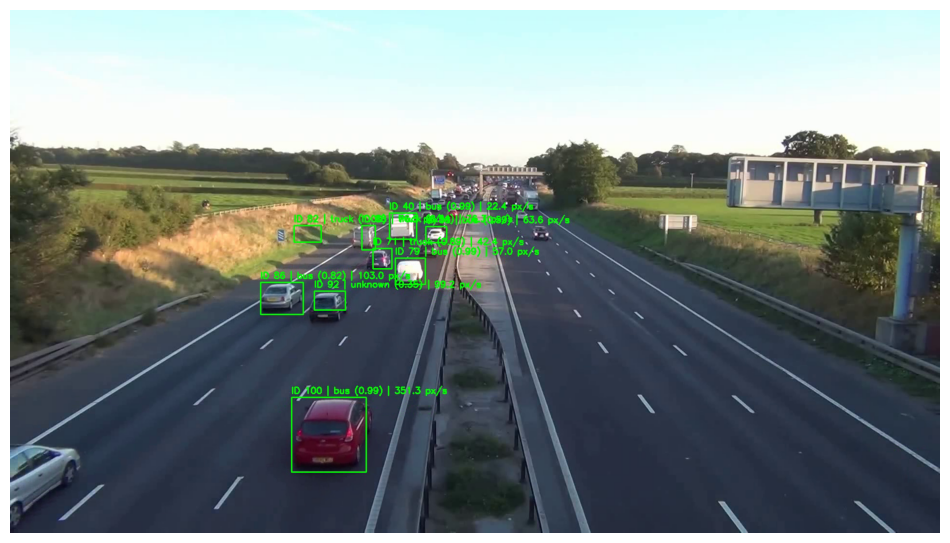

In [175]:
import cv2, matplotlib.pyplot as plt

cap = cv2.VideoCapture("annotated_tracking_speed_type_v2.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 200)
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [189]:
import cv2
import csv
from collections import defaultdict, Counter

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out_path = "annotated_tracking_speed_type_v2.mp4"
csv_path = "track_speed_type_v2.csv"

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

bg = cv2.createBackgroundSubtractorMOG2(
    history=500,
    varThreshold=32,
    detectShadows=True
)

tracker = CentroidTracker(max_lost=10, dist_thresh=60)

frame_count = 0
MAX_FRAMES = 200

rows = []

track_votes = defaultdict(Counter)

while True:
    ret, frame = cap.read()
    if not ret or frame is None:
        break

    frame_count += 1
    if frame_count > MAX_FRAMES:
        break

    roi = frame[int(h*0.35):, :]
    roi_y_offset = int(h*0.35)

    fg = bg.apply(roi)
    fg[fg == 127] = 0
    fg = cv2.medianBlur(fg, 5)
    _, fg = cv2.threshold(fg, 200, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel, iterations=1)
    fg = cv2.morphologyEx(fg, cv2.MORPH_DILATE, kernel, iterations=2)

    contours, _ = cv2.findContours(fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detections = []
    for c in contours:
        if cv2.contourArea(c) < 900:
            continue

        x, y, wc, hc = cv2.boundingRect(c)
        aspect = wc / float(hc + 1e-6)

        if wc * hc < 1400 or hc < 25 or wc < 25:
            continue
        if aspect < 0.3 or aspect > 5.0:
            continue

        detections.append((x, y + roi_y_offset, wc, hc))

    tracks = tracker.update(detections)

    for tid, t in tracks.items():
        # require track stability
        if len(t["history"]) < 12:
            continue

        x, y, wc, hc = t["bbox"]

        
        if wc < 30 or hc < 30:
            continue

        
        aspect = wc / float(hc + 1e-6)
        if aspect > 4.5 or aspect < 0.2:
            continue

        
        if (y + hc) > int(h * 0.95):
            continue

        cx, cy = t["centroid"]

        # speed (px/s)
        sp = estimate_speed_px_per_s(t["history"], fps, window=5)

        
        conf, cls_idx = vehicletypefrombbox(frame, t["bbox"], model_type)

        
        if cls_idx is not None and cls_idx < len(class_names) and conf >= 0.75:
            track_votes[tid][class_names[cls_idx]] += 1

        
        veh_type = "unknown"
        if sum(track_votes[tid].values()) >= 12:
            veh_type = track_votes[tid].most_common(1)[0][0]
        
        if veh_type == "motorcycle" and (wc > 90 or hc > 90):
            veh_type = "car"

        
        if sp is not None:
            rows.append([frame_count, tid, cx, cy, sp, veh_type, conf])

        
        cv2.rectangle(frame, (x, y), (x + wc, y + hc), (0, 255, 0), 2)

        label = f"ID {tid} | {veh_type}"
        if sp is not None:
            label += f" | {sp:.1f} px/s"

        cv2.putText(frame, label, (x, max(20, y - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    writer.write(frame)


with open(csv_path, "w", newline="") as f:
    wcsv = csv.writer(f)
    wcsv.writerow(["frame","track_id","cx","cy","speed_pxps","vehicle_type","type_conf"])
    wcsv.writerows(rows)

cap.release()
writer.release()

print("Saved:", out_path)
print("Saved CSV:", csv_path, "rows:", len(rows))


Saved: annotated_tracking_speed_type_v2.mp4
Saved CSV: track_speed_type_v2.csv rows: 1424


In [192]:
import os

f = "annotated_tracking_speed_type_v2.mp4"
print("Exists:", os.path.exists(f))
if os.path.exists(f):
    print("Size (bytes):", os.path.getsize(f))


Exists: True
Size (bytes): 11959074


Total frames: 200


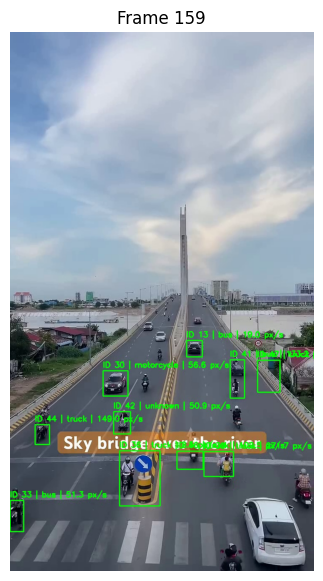

In [197]:
import cv2, matplotlib.pyplot as plt

cap = cv2.VideoCapture("annotated_tracking_speed_type_v2.mp4")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames:", total_frames)

# pick a valid frame index
idx = min(159, total_frames - 1)

cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
ret, frame = cap.read()
cap.release()

if not ret or frame is None:
    print(" Could not read frame")
else:
    plt.figure(figsize=(12,7))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Frame {idx}")
    plt.show()


In [198]:
from IPython.display import FileLink
FileLink("annotated_tracking_speed_type_v2.mp4")


/kaggle/working/annotated_tracking_speed_type_v2.mp4